In [1]:
import os
import random
import shutil
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.models import mobilenet_v2




# **Prepare my dataset**

In [2]:
# Set the paths to your dataset folders
bag_folder = '/kaggle/input/slash-dataset/slash/bag'
clothes_folder = '/kaggle/input/slash-dataset/slash/clothes'

# Set the paths for the train and test folders
train_folder = '/kaggle/working/slash-dataset/train'
test_folder = '/kaggle/working/slash-dataset/test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)



In [3]:
# split the dataset
train_ratio = 0.8
def split_dataset(source_folder, train_destination, test_destination, ratio):
    files = os.listdir(source_folder)
    random.shuffle(files)
    train_files = files[:int(len(files) * ratio)]
    test_files = files[int(len(files) * ratio):]

    for file in train_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_destination, file))

    for file in test_files:
        shutil.copy(os.path.join(source_folder, file), os.path.join(test_destination, file))

split_dataset(bag_folder, train_folder, test_folder, train_ratio)

split_dataset(clothes_folder, train_folder, test_folder, train_ratio)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, directory, transform=None, is_test=False):
        self.directory = directory
        self.transform = transform
        self.is_test = is_test
        self.images, self.labels = self.load_images()

    def load_images(self):
        images = []
        labels = []
        if self.is_test:
            # For test data, labels are not available
            for img_file in os.listdir(self.directory):
                img_path = os.path.join(self.directory, img_file)
                images.append(img_path)
                labels.append(-1)  # Dummy label for test data
        else:
            # For train and validation data
            classes = ['bag', 'clothes']
            label_map = {class_name: index for index, class_name in enumerate(classes)}
            for img_file in os.listdir(self.directory):
                img_path = os.path.join(self.directory, img_file)
                images.append(img_path)
                # Extract the label from the filename
                class_name = img_file.split('.')[0]
                label = 0 if class_name.startswith('bag') else 1
                labels.append(label_map[classes[label]])


        return images, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, img_path

In [5]:
# Placeholder for image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256

    # Randomly apply data augmentations
      transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
      transforms.RandomRotation(10),      # Randomly rotate the image by 10 degrees
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Randomly change brightness, contrast, and saturation
      transforms.RandAugment(8,2),
      transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      transforms.RandomErasing(0.3),
])


In [6]:
train_dir = '/kaggle/working/slash-dataset/train'
train_dataset = CustomDataset(train_dir, transform=transform)



In [7]:
# Splitting the dataset into training and validation
train_idx, val_idx = train_test_split(list(range(len(train_dataset))), test_size=0.05)
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
batch_size = 30


In [8]:
# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)



In [9]:
# Test dataset
test_dir = '/kaggle/working/slash-dataset/test'
test_dataset = CustomDataset(test_dir, transform=transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **MobileNetV1 from scratch**

In [10]:
# model architecture 

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1Binary(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5, weight_decay=1e-4):
        super(MobileNetV1Binary, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            DepthwiseSeparableConv(32, 64, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(64, 128, 2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(128, 128, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(128, 256, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(256, 256, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(256, 512, 2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # repeated block
            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(512, 512, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # End of repeated block

            DepthwiseSeparableConv(512, 1024, 2),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            DepthwiseSeparableConv(1024, 1024, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout_prob)

        # Apply weight regularization to convolutional and fully connected layers
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.weight.data = nn.init.kaiming_normal_(layer.weight.data)
                if layer.bias is not None:
                    layer.bias.data.fill_(0)
                # Apply weight decay
                layer.weight.data *= (1.0 - weight_decay)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.dropout(x)
        x = self.fc(x)
        return x


# **AlexNet from scratch**

In [11]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.pool3 = nn.MaxPool2d(2, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x

# **Fine tuning pre-trained MobileNet**

In [12]:
# Load pre-trained MobileNet
model = mobilenet_v2(pretrained=True)

# Freeze layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)  # Assuming you have 2 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 125MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = MobileNetV1Binary(num_classes=2).to(device)
#model =AlexNet().to(device)

# **Training**

In [14]:
import torch.optim as optim

ldl = len(train_loader) 

bestScore = 0
patience = 50         
num_epochs = 15
best_epoch = 0
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
# Alternatively, scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [15]:
def train(model, dataloader, loss_fn, optimizer, device, ldl, lts): ## ldl = length dataloader, lts = length dataset
    model.train()  ## puts the model on training mode such as enabling gradient computations
    total_loss = 0 ## over current epoch
    
    total_correct = 0 ## extra, calculate the accuracy on training set during epoch
    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad() ## deletes stored gradients 
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()     ## computes gradients
        optimizer.step()    ## updates parameters   
        
        total_loss += loss.item()
        
        predictions = outputs.argmax(dim=1)

        correct = (predictions == labels).sum().item()
        total_correct += correct
        
    return total_loss / ldl, total_correct / lts


In [16]:
def compute_accuracy(dataloader, model):
    model.eval()  # switch to evaluation mode

    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_count += len(labels)

    accuracy = total_correct / total_count

    return accuracy

Epoch 15/15, Train Loss: 0.2293, lr: 0.0000109
Validation Acc: 1.0000, Train Acc: 0.7889


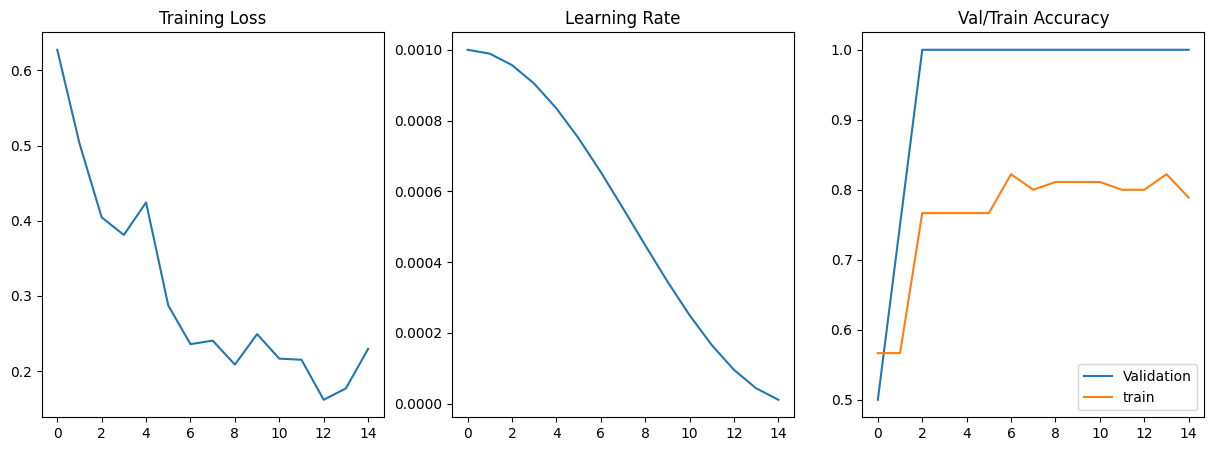

Patience REM :  12


In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

## the following lists will be used to plot the loss and accuracy curves by keeping track of the values over epochs
train_losses = []
cross_accs = []
train_accs = []
lr = []
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, device, ldl, ldl*batch_size)
    CurrentScore = compute_accuracy(val_loader, model)

    lr.append(optimizer.param_groups[0]['lr'])
    train_losses.append(train_loss)
    cross_accs.append(CurrentScore)
    train_accs.append(train_acc)
    clear_output(wait=True) # wait for all plots to be shown, then erase them and display the updated ones

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, lr: {lr[-1]:.7f}')
    print(f'Validation Acc: {CurrentScore:.4f}, Train Acc: {train_acc:.4f}')
    scheduler.step()

    # initialize 3 subplots to plot the loss curve, learning rate curve and accuracy curve
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].plot(train_losses)
    axs[0].set_title('Training Loss')
    axs[1].plot(lr)
    axs[1].set_title('Learning Rate')
    axs[2].plot(cross_accs, label="Validation")
    axs[2].plot(train_accs, label = "train")
    axs[2].set_title('Val/Train Accuracy')
    axs[2].legend()
    plt.show(block=False)
    print("Patience REM : ", epoch - best_epoch)
    if CurrentScore > bestScore:
        bestScore = CurrentScore
        best_epoch = epoch
        torch.save(model.state_dict(), 'sad_model.pt')
    elif epoch - best_epoch >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Training stopped.')
        torch.save(combined_model.state_dict(), f'model_epoch_{epoch}.pt')
        break


In [19]:
torch.save(model, "/kaggle/working/Model.pth")


# **Evaluation**

In [20]:
import time
model.eval() 
infloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False) ## create a dummy datalaoder with batchsize = 1
img= next(iter(infloader))[0] ## takes next batch from this dataloader which is just 1 sample
img = img.to(device)
start = time.time() ## record start time
_= model(img)
end = time.time() ## records end time
print(end - start)

0.05988478660583496


# **Prediction**

In [26]:
import torch
from tqdm import tqdm

# Load the trained model
model = torch.load("/kaggle/working/Model.pth")
model.eval()  # Set the model to evaluation mode

predictions = []  # Store predictions

# Iterate through the test dataset
for images, _, img_paths in tqdm(test_loader):
    # Move images to the device
    images = images.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(images)
        predictions.extend(outputs.argmax(dim=1).cpu().numpy())

# Map predictions to class labels
class_labels = {0: 'bag', 1: 'clothes'}
predicted_labels = [class_labels[pred] for pred in predictions]

test_image_names = [os.path.basename(img_path) for img_path in test_dataset.images]

# Print the predictions
for img_name, pred_label in zip(test_image_names, predicted_labels):
    print(f"Image: {img_name}, Predicted Label: {pred_label}")


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

Image: bag39.png, Predicted Label: bag
Image: clothes32.png, Predicted Label: clothes
Image: bag29.png, Predicted Label: bag
Image: clothes38.png, Predicted Label: clothes
Image: bag40.png, Predicted Label: bag
Image: bag4.png, Predicted Label: bag
Image: clothes20.png, Predicted Label: clothes
Image: clothes17.png, Predicted Label: clothes
Image: bag8.png, Predicted Label: bag
Image: bag55.png, Predicted Label: bag
Image: bag2.png, Predicted Label: bag
Image: bag11.png, Predicted Label: bag
Image: clothes37.png, Predicted Label: clothes
Image: bag10.png, Predicted Label: bag
Image: clothes14.png, Predicted Label: clothes
Image: clothes8.png, Predicted Label: clothes
Image: bag18.png, Predicted Label: bag
Image: bag51.png, Predicted Label: bag
Image: bag58.png, Predicted Label: bag
Image: clothes1.png, Predicted Label: clothes
Image: clothes10.png, Predicted Label: clothes
